# Unsupervised Learning

(unsupervised_async)=
## To do before...

{ref}`💻 [Async] <delivery_modes>`

Before we jump on the action, we are going to get some background on unsupervised learning. Please complete watching the following three clips, all sourced from the [Geographic Data Science course](https://darribas.org/gds_course/):

1. [*The need to group data*](https://darribas.org/gds_course/content/bG/concepts_G.html#the-need-to-group-data), which describes *why* unsupervised learning is useful
1. [*Non-spatial clustering*](https://darribas.org/gds_course/content/bG/concepts_G.html#non-spatial-clustering), which describes *what* unsupervised learning is and illustrates it
1. [*K-Means*](https://darribas.org/gds_course/content/bG/concepts_G.html#k-means), which introduces the technique we'll use in class and, by far, most popular one to cluster data



(unsupervised_sync)=
## Action!

{ref}`👨‍🏫 [Sync] <delivery_modes>`

In [1]:
import pandas
from numpy.random import seed

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

orig = pandas.read_csv("../data/paris_abb.csv.zip")
reviews = pandas.read_csv("../data/paris_abb_review.csv.zip")
db = orig.join(reviews.set_index("id"), on="id")

### Explore

In [2]:
review_areas = ["review_scores_accuracy",
                "review_scores_cleanliness",
                "review_scores_checkin",
                "review_scores_communication",
                "review_scores_location",
                "review_scores_value"
               ]

In [3]:
db[review_areas].describe().T

,count,mean,std,min,25%,50%,75%,max
review_scores_accuracy,50280.0,9.576929,0.824413,2.0,9.0,10.0,10.0,10.0
review_scores_cleanliness,50280.0,9.178540,1.107574,2.0,9.0,9.0,10.0,10.0
review_scores_checkin,50280.0,9.660302,0.769064,2.0,10.0,10.0,10.0,10.0
review_scores_communication,50280.0,9.703520,0.727020,2.0,10.0,10.0,10.0,10.0
review_scores_location,50280.0,9.654018,0.696448,2.0,9.0,10.0,10.0,10.0
review_scores_value,50280.0,9.254515,0.930852,2.0,9.0,9.0,10.0,10.0


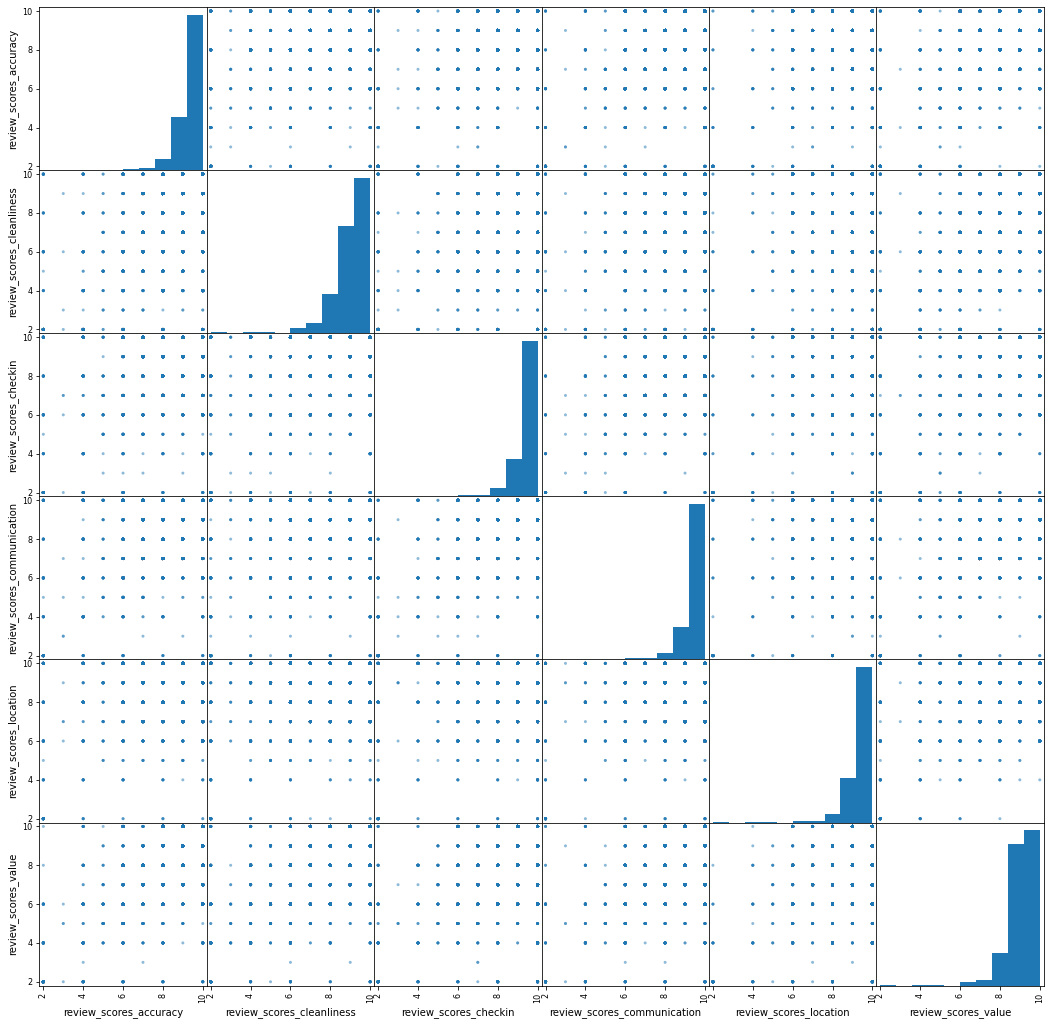

In [4]:
pandas.plotting.scatter_matrix(db[review_areas],
                               figsize=(18, 18));

This 👆, into a composite index.

### Classify

`scikit-learn` has a very consistent API (learn it once, use it across). It comes in a few flavors:

    - `fit`
    - `fit_transform`
    - Direct method

- All raw

In [5]:
estimator = KMeans(n_clusters = 5)
estimator

KMeans(n_clusters=5)

In [6]:
seed(12345)

estimator.fit(db[review_areas])

KMeans(n_clusters=5)

In [7]:
k5_raw = pandas.Series(estimator.labels_,
                       index=db.index
                      )
k5_raw.head()

0    3
1    0
2    1
3    3
4    3
dtype: int32

**NOTE** `fit`

- All standardised

In [8]:
# Minus mean, divided by std
db_stded = scale(db[review_areas])
pandas.DataFrame(db_stded, 
                 index = db.index,
                 columns = review_areas
                ).describe()\
                 .reindex(["mean", "std"])

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
mean,2.450638e-14,1.191311e-14,-3.519940e-14,-3.060389e-14,-1.223943e-14,1.039476e-16
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00


**NOTE** `scale` API

In [9]:
# Range scale
range_scaler = MinMaxScaler()
db_scaled = range_scaler.fit_transform(db[review_areas])
pandas.DataFrame(db_scaled,
                 index = db.index,
                 columns = review_areas
                ).describe()\
                 .reindex(["min", "max"])

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
min,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0


**NOTE** `fit_transform`

In [10]:
seed(12345)

estimator = KMeans(n_clusters = 5)

estimator.fit(db_stded)

k5_std = pandas.Series(estimator.labels_,
                       index=db.index
                      )
k5_std.head()

0    0
1    4
2    0
3    0
4    0
dtype: int32

- Projected to lower dimension

In [11]:
pca_estimator = PCA(n_components=2)
pca_estimator

PCA(n_components=2)

In [12]:
components = pca_estimator.fit_transform(db[review_areas])
components = pandas.DataFrame(components,
                              index = db.index,
                              columns = ["C-1", "C-2"]
                             )

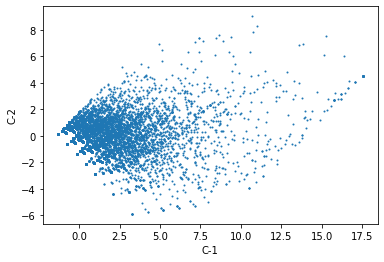

In [13]:
components.plot.scatter("C-1", 
                        "C-2",
                        s=1
                       );

Now we cluster the two components instead of all the input variables:

In [14]:
seed(12345)
estimator = KMeans(n_clusters = 5)
estimator.fit(components)
k5_pca = pandas.Series(estimator.labels_,
                       index=components.index
                      )

We can compare how both solutions relate to each other (or not):

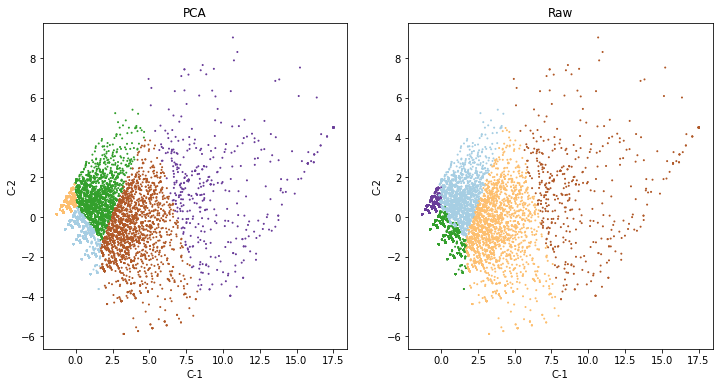

In [15]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))

ax = axs[0]
components.assign(labels=k5_pca)\
          .plot.scatter("C-1", 
                        "C-2",
                        c="labels",
                        s=1,
                        cmap="Paired",
                        colorbar=False,
                        ax=ax
                       )
ax.set_title("PCA")

ax = axs[1]
components.assign(labels=k5_raw)\
          .plot.scatter("C-1", 
                        "C-2",
                        c="labels",
                        s=1,
                        cmap="Paired",
                        colorbar=False,
                        ax=ax
                       )
ax.set_title("Raw")

plt.show()

Actually pretty similar (which is good!). But remember that our original input was expressed in the same units anyway, so it makes sense.

---

**EXERCISE**: Add a third plot to the figure above visualising the labels with the range-scaled transformation.

---

### Explore the classification

- Quality of clustering ([Calinski and Harabasz score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html), the ratio of between over within dispersion)

In [16]:
chs_raw = calinski_harabasz_score(db[review_areas],
                                  k5_raw
                                 )

In [17]:
chs_std = calinski_harabasz_score(db[review_areas],
                                  k5_std
                                 )

In [18]:
chs_pca = calinski_harabasz_score(db[review_areas],
                                  k5_pca
                                 )

In [19]:
pandas.Series({"Raw": chs_raw,
               "Standardised": chs_std,
               "PCA": chs_pca,
              })

Raw             16548.489419
Standardised    14674.706963
PCA             16519.822001
dtype: float64

The higher, the better, so either the original or PCA.

We can also use this to "optimise" (or at least explore its behaviour) the number of clusters. Let's pick the original input as the scores suggest are more desirable:

In [20]:
%%time
seed(12345)

chss = {}
for i in [2, 5, 10, 15, 20, 30]:
    estimator = KMeans(n_clusters=i)
    estimator.fit(components)
    chs = calinski_harabasz_score(db[review_areas], 
                                  estimator.labels_
                                 )
    chss[i] = chs
chss = pandas.Series(chss)

CPU times: user 2min 32s, sys: 1min 9s, total: 3min 42s
Wall time: 14.6 s


<AxesSubplot:>

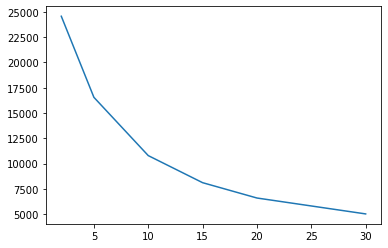

In [21]:
chss.plot.line()

5 clusters? 🤔

- Quality of clustering ([silhouette scores](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient))

In [22]:
%%time
sil_raw = silhouette_score(db[review_areas], 
                           k5_raw,
                           metric="euclidean"
                          )

CPU times: user 1min 3s, sys: 4min 38s, total: 5min 41s
Wall time: 41.5 s


In [23]:
%%time
sil_std = silhouette_score(db[review_areas], 
                           k5_std,
                           metric="euclidean"
                          )

CPU times: user 1min 4s, sys: 4min 28s, total: 5min 33s
Wall time: 41.3 s


In [24]:
%%time
sil_pca = silhouette_score(db[review_areas], 
                           k5_pca,
                           metric="euclidean"
                          )

CPU times: user 1min 5s, sys: 4min 22s, total: 5min 28s
Wall time: 41 s


In [25]:
pandas.Series({"Raw": sil_raw,
               "Standardised": sil_std,
               "PCA": sil_pca,
              })

Raw             0.314448
Standardised    0.304222
PCA             0.314263
dtype: float64

For a graphical analysis of silhouette scores, see here:

> [https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)


---

**EXERCISE** Compare silhouette scores across our three original approaches for three and 20 clusters

---

- Characterise

Internally:

In [26]:
g = db[review_areas]\
      .groupby(k5_pca)

In [27]:
g.size()\
 .sort_values()

3      437
4     2850
1     7752
0    16468
2    22773
dtype: int64

In [28]:
g.mean()

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,9.705186,8.728564,9.867379,9.907335,9.759716,9.331188
1,9.020253,8.901961,8.986068,9.084752,9.288442,8.639706
2,9.931366,10.000000,9.923989,9.949370,9.822992,9.699864
3,4.993135,4.789474,5.665904,5.734554,7.212815,4.528604
4,8.220702,6.640000,8.803158,8.852982,9.061754,7.649825


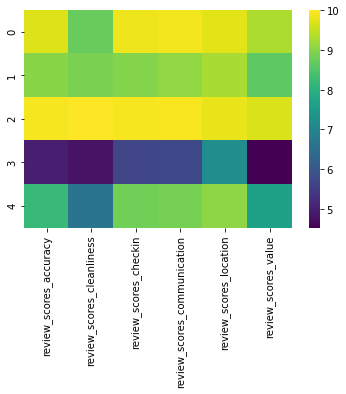

In [29]:
sns.heatmap(g.mean(), cmap='viridis');

To explore the _distribution_ of the values inside each cluster, rather than their mean, we can use the fancy `FaceGrid` approach:

In [30]:
tidy_db = db[review_areas]\
            .stack()\
            .reset_index()\
            .rename(columns={"level_1": "Var",
                             "level_0": "ID",
                             0: "Value"
                            })\
            .join(pandas.DataFrame({"Label": k5_pca}),
                  on="ID")
tidy_db.head()

,ID,Var,Value,Label
0,0,review_scores_accuracy,10.0,2
1,0,review_scores_cleanliness,10.0,2
2,0,review_scores_checkin,10.0,2
3,0,review_scores_communication,10.0,2
4,0,review_scores_location,10.0,2


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


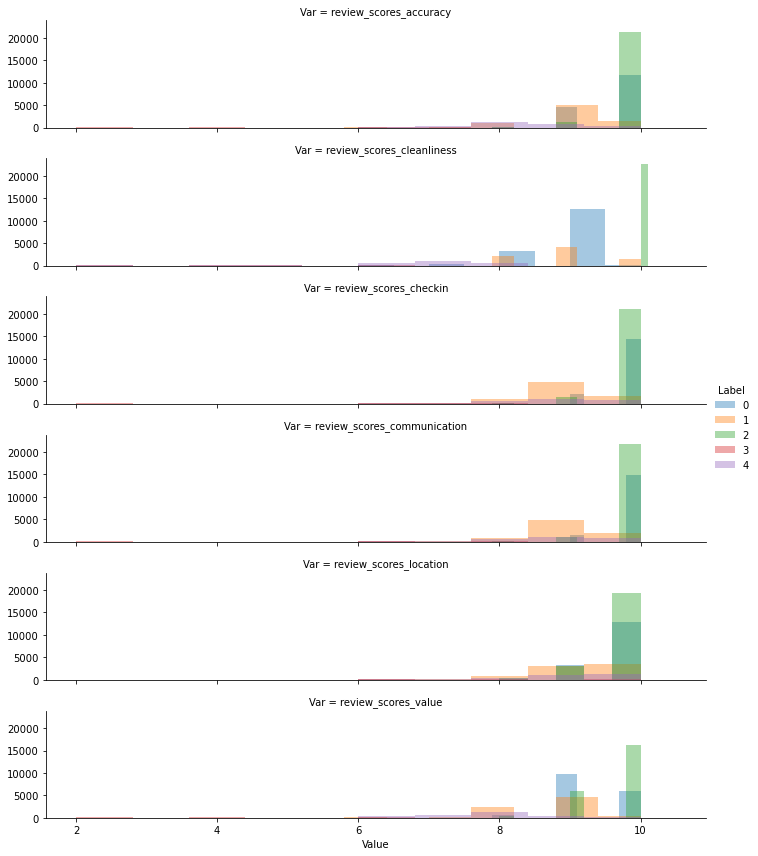

In [31]:
g = sns.FacetGrid(tidy_db,
                  row="Var",
                  hue="Label",
                  height=2,
                  aspect=5
                 )
g.map(sns.distplot, 
      "Value", 
      hist=True,
      bins=10,
      kde=False,
      rug=False
     )
g.add_legend();

---

Externally:

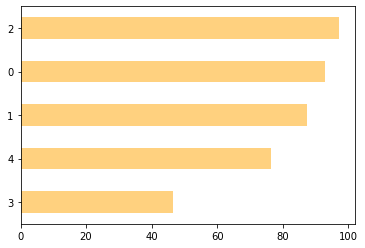

In [32]:
# Cross with review_scores_rating
db.groupby(k5_pca)\
  ["review_scores_rating"]\
  .mean()\
  .sort_values()\
  .plot.barh(color="orange",
             alpha=0.5
            );

---

**EXERCISE** Can you cross the clustering results with property prices? Create:

- A bar plot with the average price by cluster
- A plot with the distribution (KDE/hist) of prices within cluster

---

Before we move on, let's also save the labels of the results:

In [33]:
pandas.DataFrame({"k5_pca": k5_pca})\
      .to_parquet("../data/k5_pca.parquet")